- QUAH JUN CHUAN 22004851
- TER ZHEN HUANG 22004736
- CHENG YEE ERN 22004791
- RACHEL LIM 22052702



In [904]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [905]:
# Load your dataset
df = pd.read_csv('Copy of Data_Cortex_Nuclear.csv')

### Check for missing value

In [906]:
# Check for missing values
missing_values = df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
DYRK1A_N        3
ITSN1_N         3
BDNF_N          3
NR1_N           3
NR2A_N          3
pAKT_N          3
pBRAF_N         3
pCAMKII_N       3
pCREB_N         3
pELK_N          3
pERK_N          3
pJNK_N          3
PKCA_N          3
pMEK_N          3
pNR1_N          3
pNR2A_N         3
pNR2B_N         3
pPKCAB_N        3
pRSK_N          3
AKT_N           3
BRAF_N          3
CAMKII_N        3
CREB_N          3
ELK_N          18
ERK_N           3
GSK3B_N         3
JNK_N           3
MEK_N           7
TRKA_N          3
RSK_N           3
APP_N           3
Bcatenin_N     18
SOD1_N          3
MTOR_N          3
P38_N           3
pMTOR_N         3
DSCR1_N         3
AMPKA_N         3
NR2B_N          3
pNUMB_N         3
RAPTOR_N        3
TIAM1_N         3
pP70S6_N        3
BAD_N         213
BCL2_N        285
pCFOS_N        75
H3AcK18_N     180
EGR1_N        210
H3MeK4_N      270
dtype: int64


## Data Preprocessing

In [907]:
distinct_values = df['class'].unique()
print("Distinct values in 'class' column:", distinct_values)

Distinct values in 'class' column: ['c-CS-m' 'c-SC-m' 'c-CS-s' 'c-SC-s' 't-CS-m' 't-SC-m' 't-CS-s' 't-SC-s']


#### Mean Imputation

In [908]:
# Perfome Mean Imputation to fill in missiong value
class_labels = ['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m', 't-CS-s', 't-SC-s']

# Iterate over each class label
filled_dfs = []
for label in class_labels:
    # 1. Filter the DataFrame to include only rows where the 'class' is the current label
    class_data = df[df['class'] == label]

    # 2. Calculate the mean value for each feature in the filtered data
    mean_values_class = class_data.mean(numeric_only=True)  # Specify numeric_only=True to silence the warning

    # 3. Fill the missing values in each feature with the corresponding mean value
    filled_class_data = class_data.fillna(mean_values_class)

    # Append the filled data to the list
    filled_dfs.append(filled_class_data)

# Concatenate the filled data for all classes back together
filled_df = pd.concat(filled_dfs)


In [909]:
# Check for missing values
missing_values = filled_df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
Series([], dtype: int64)


#### Convert class from string to integer

In [910]:
filled_df['class'] = df['class'].replace(['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m', 't-CS-s', 't-SC-s'], range(8))

# Print the updated DataFrame
print(filled_df['class'])

0       0
1       0
2       0
3       0
4       0
       ..
1075    7
1076    7
1077    7
1078    7
1079    7
Name: class, Length: 1080, dtype: int64


In [911]:
# Split the dataset into features and target
X = filled_df.drop(columns=['class'])
y = filled_df['class']

## Data Visualisation for Feature Selection

#### ANOVA test for to find top 10 features with smallest p-value


In [912]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df.rename(columns={'class': 'class_label'}, inplace=True)

numerical_columns = [col for col in df.columns if col not in ['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class_label']]

p_values = {}

for numerical_variable in numerical_columns:
    formula = f"{numerical_variable} ~ C(class_label)"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc['C(class_label)', 'PR(>F)']
    p_values[numerical_variable] = p_value

sorted_p_values = sorted(p_values.items(), key=lambda x: x[1])

print("Top 10 features with the smallest p-values:")
for feature, p_value in sorted_p_values[:10]:
    print(f"{feature}: {p_value}")


Top 10 features with the smallest p-values:
SOD1_N: 1.0367238009076876e-243
CaNA_N: 5.372624266691846e-215
Ubiquitin_N: 1.6289861770848514e-162
ARC_N: 1.728613890605033e-145
pS6_N: 1.728613890605033e-145
P38_N: 8.03301835718573e-142
S6_N: 1.2503547646624504e-110
pPKCAB_N: 1.2819936718030727e-108
pGSK3B_N: 7.114063353273567e-100
pERK_N: 7.809330475505706e-99


#### Box Plot Visualisation 

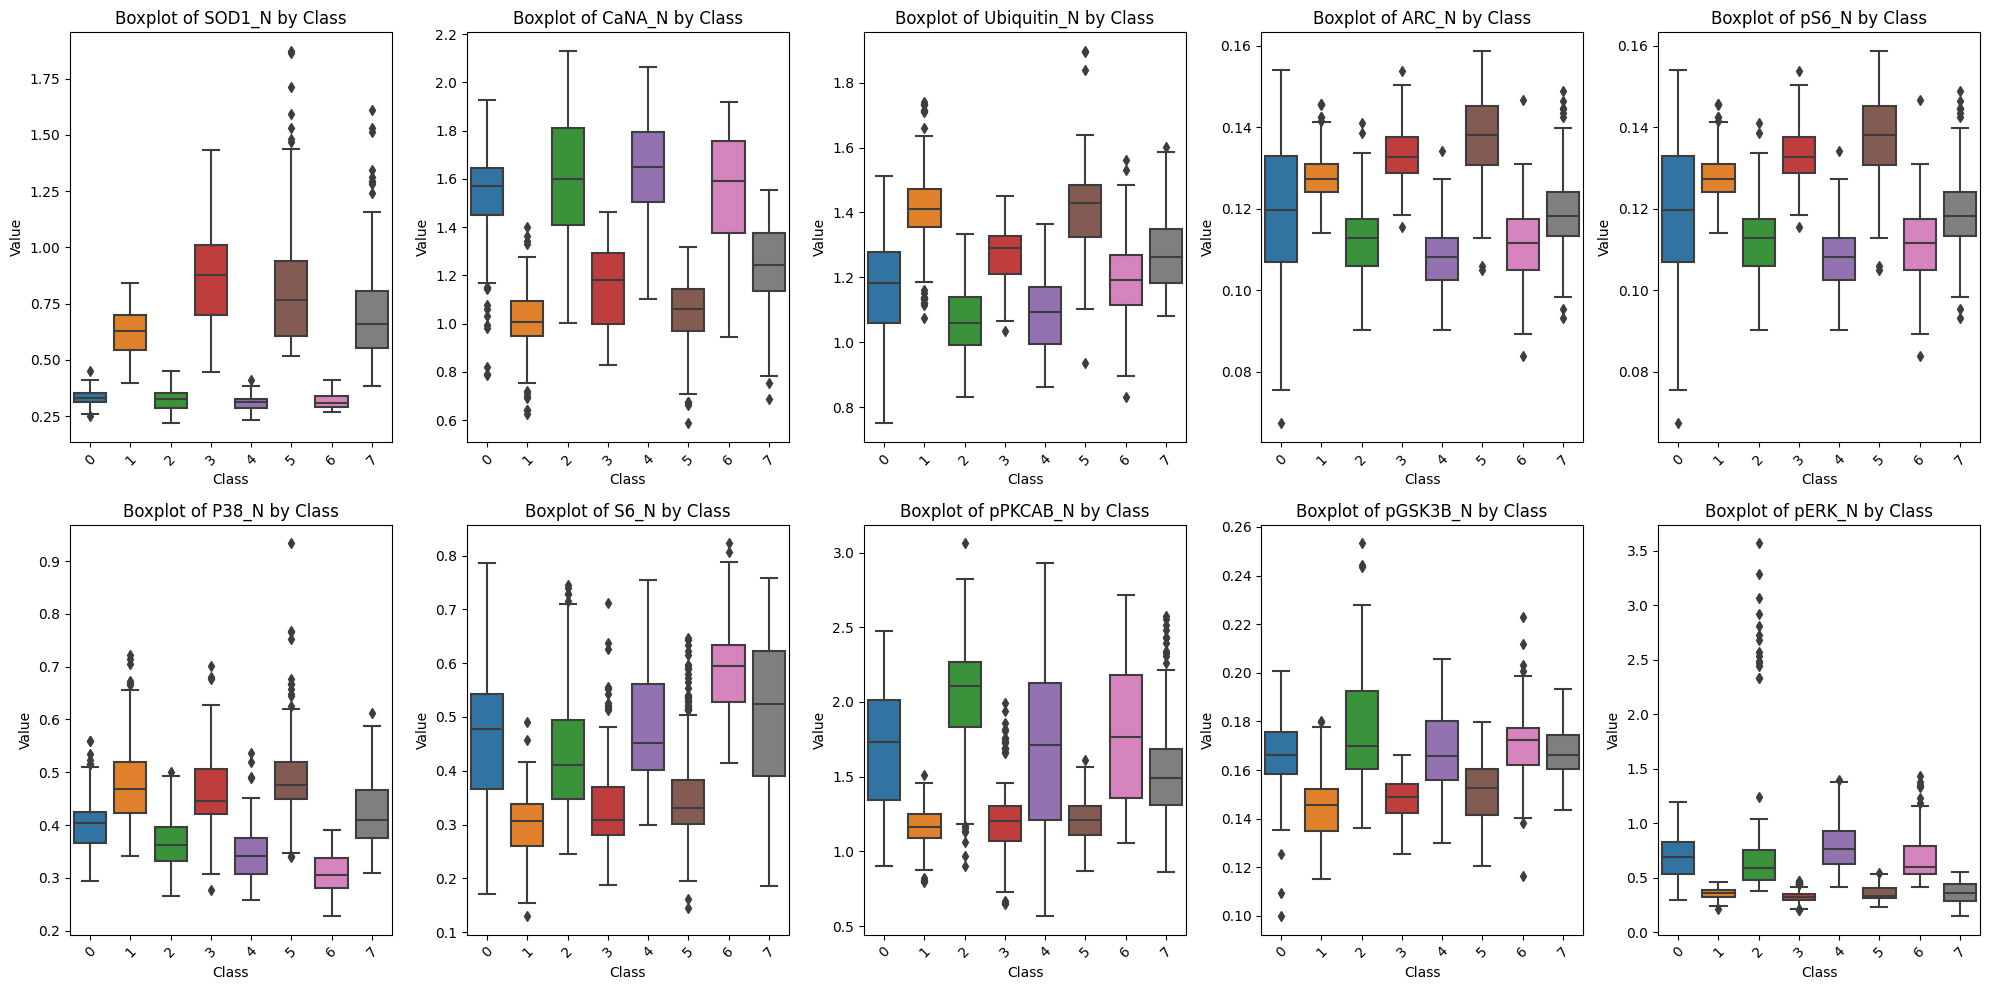

In [913]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the top 10 features with the smallest p-values
top_features = ['SOD1_N', 'CaNA_N', 'Ubiquitin_N', 'ARC_N', 'pS6_N', 'P38_N', 'S6_N', 'pPKCAB_N',
                'pGSK3B_N', 'pERK_N']

# Plot boxplots for each feature separately for each class
num_plots = len(top_features)
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, feature in enumerate(top_features):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x='class', y=feature, data=filled_df, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by Class')
    axes[row, col].set_xlabel('Class')
    axes[row, col].set_ylabel('Value')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Input Fuzzification

#### Define input and output variables

In [914]:
SOD1_N = ctrl.Antecedent(np.arange(0.25, 2.01, 0.1), 'SOD1_N')
CaNA_N = ctrl.Antecedent(np.arange(0.5, 2.21, 0.1), 'CaNA_N')
Ubiquitin_N = ctrl.Antecedent(np.arange(0.5, 2.01, 0.1), 'Ubiquitin_N')
ARC_N = ctrl.Antecedent(np.arange(0.02, 0.17, 0.01), 'ARC_N')
pS6_N = ctrl.Antecedent(np.arange(0.02, 0.17, 0.01), 'pS6_N')
P38_N = ctrl.Antecedent(np.arange(0.2, 1.01, 0.1), 'P38_N')
S6_N = ctrl.Antecedent(np.arange(0.1, 0.91, 0.1), 'S6_N')
pPKCAB_N = ctrl.Antecedent(np.arange(0.5, 3.01, 0.1), 'pPKCAB_N')
pGSK3B_N = ctrl.Antecedent(np.arange(0.1, 0.27, 0.01), 'pGSK3B_N')
pERK_N = ctrl.Antecedent(np.arange(0.1, 3.51, 0.1), 'pERK_N')

# Define output variable
class_label = ctrl.Consequent(np.arange(0, 8, 1), 'class_label')

### Model A

#### Manually define membership functions for input variables - Each degree with different membership function

In [915]:
# Manually define membership value for multi-variate membership function
mf_val = np.array([
    0.25, 0.50, 
    0.35, 0.60, 0.80,
    0.4, 1.0,

    0.7, 1.3,
    0.8, 1.1, 1.5,
    1.0, 2.15,

    0.7, 1.5, 
    1.05, 1.3, 1.6,
    1.1, 1.65,
    
    0.075,0.13,
    0.075,0.110,0.155,
    0.11,0.16,
    
    0.075,0.13,
    0.075,0.110,0.155,
    0.11,0.16,

    0.1, 0.5, 
    0.3, 0.45, 0.6,
    0.32, 0.68,

    0.15, 0.52,
    0.17, 0.45, 0.79,
    0.2, 0.79,
    
    0.75, 1.3,
    0.6, 1.7, 2.85,
    1.2, 2.8,
    
    0.11,0.18,
    0.135,0.18,0.21,
    0.135,0.23,
    
    0.2, 0.5,
    0.3, 0.8, 1.2,
    0.4 ,1.4,
])

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


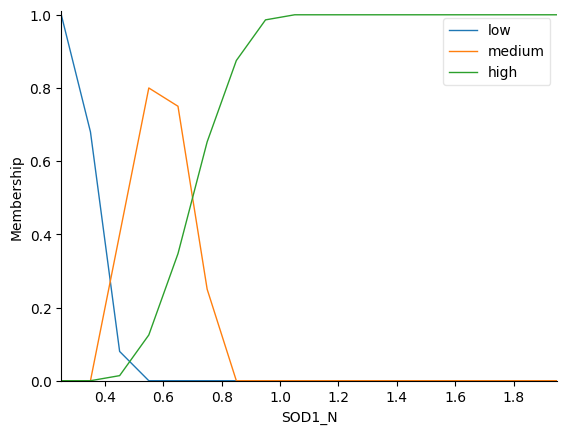

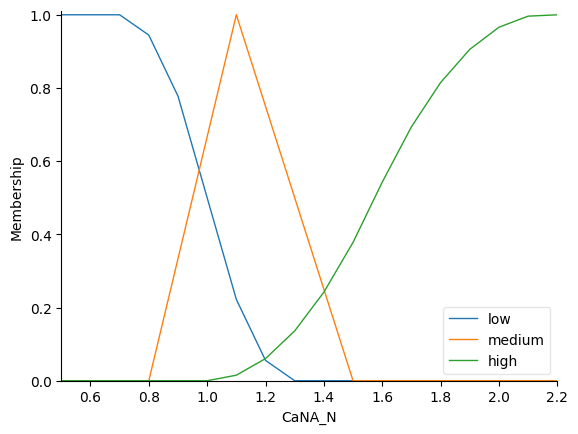

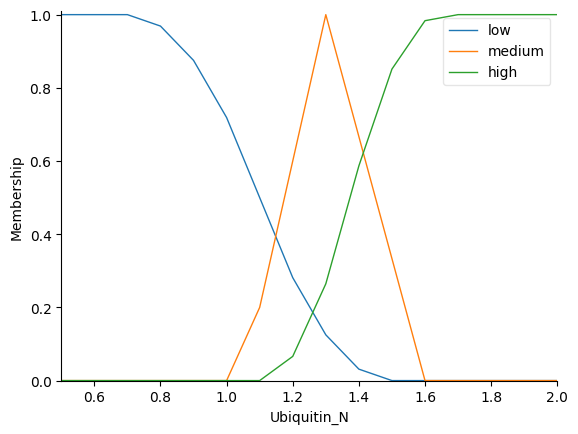

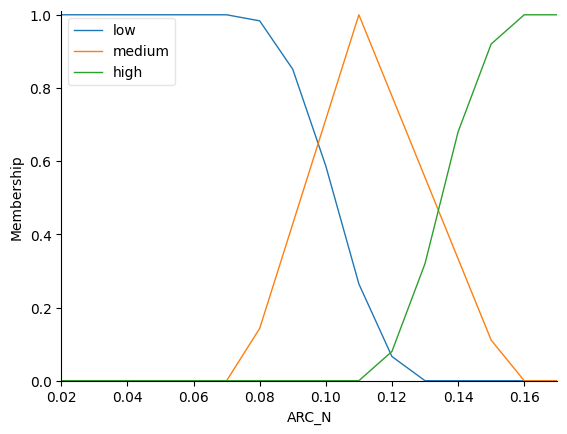

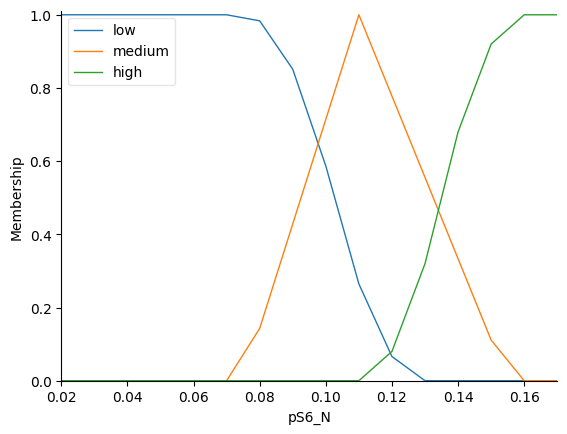

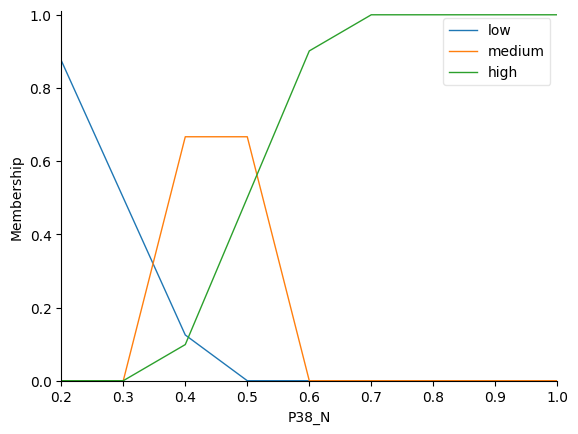

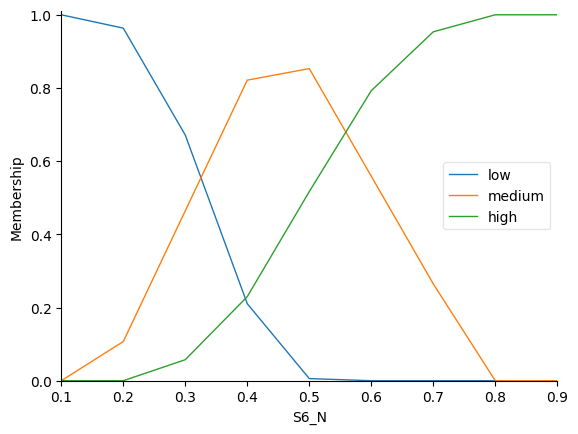

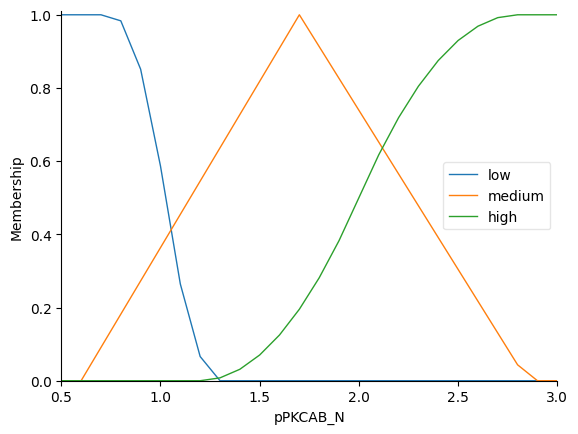

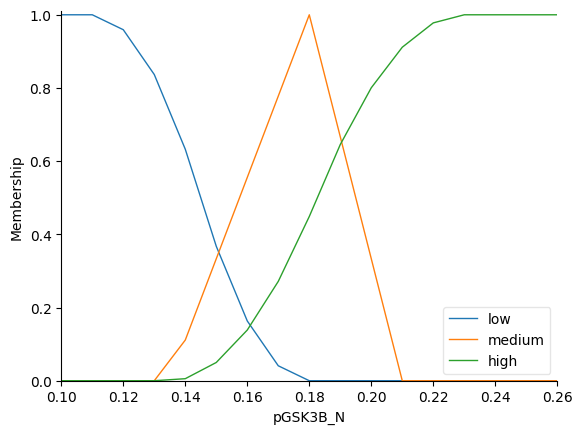

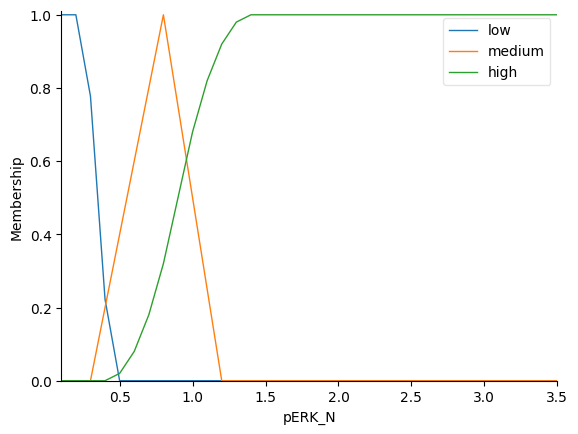

In [916]:
# Define membership function by using value in array
SOD1_N['low'] = fuzz.zmf(SOD1_N.universe, mf_val[0], mf_val[1])  
SOD1_N['medium'] = fuzz.trimf(SOD1_N.universe, [mf_val[2], mf_val[3], mf_val[4]])
SOD1_N['high'] = fuzz.smf(SOD1_N.universe, mf_val[5], mf_val[6])  

CaNA_N['low'] = fuzz.zmf(CaNA_N.universe, mf_val[7], mf_val[8])  
CaNA_N['medium'] = fuzz.trimf(CaNA_N.universe, [mf_val[9], mf_val[10], mf_val[11]])
CaNA_N['high'] = fuzz.smf(CaNA_N.universe, mf_val[12], mf_val[13])  

Ubiquitin_N['low'] = fuzz.zmf(Ubiquitin_N.universe, mf_val[14], mf_val[15])
Ubiquitin_N['medium'] = fuzz.trimf(Ubiquitin_N.universe, [mf_val[16], mf_val[17], mf_val[18]])
Ubiquitin_N['high'] = fuzz.smf(Ubiquitin_N.universe, mf_val[19], mf_val[20])

ARC_N['low'] = fuzz.zmf(ARC_N.universe, mf_val[21], mf_val[22])
ARC_N['medium'] = fuzz.trimf(ARC_N.universe, [mf_val[23], mf_val[24], mf_val[25]])
ARC_N['high'] = fuzz.smf(ARC_N.universe, mf_val[26], mf_val[27])

pS6_N['low'] = fuzz.zmf(pS6_N.universe, mf_val[28], mf_val[29])
pS6_N['medium'] = fuzz.trimf(pS6_N.universe, [mf_val[30], mf_val[31], mf_val[32]])
pS6_N['high'] = fuzz.smf(pS6_N.universe, mf_val[33], mf_val[34])

P38_N['low'] = fuzz.zmf(P38_N.universe, mf_val[35], mf_val[36])
P38_N['medium'] = fuzz.trimf(P38_N.universe, [mf_val[37], mf_val[38], mf_val[39]])
P38_N['high'] = fuzz.smf(P38_N.universe, mf_val[40], mf_val[41])

S6_N['low'] = fuzz.zmf(S6_N.universe, mf_val[42], mf_val[43])
S6_N['medium'] = fuzz.trimf(S6_N.universe, [mf_val[44], mf_val[45], mf_val[46]])
S6_N['high'] = fuzz.smf(S6_N.universe, mf_val[47], mf_val[48])

pPKCAB_N['low'] = fuzz.zmf(pPKCAB_N.universe, mf_val[49], mf_val[50])
pPKCAB_N['medium'] = fuzz.trimf(pPKCAB_N.universe, [mf_val[51], mf_val[52], mf_val[53]])
pPKCAB_N['high'] = fuzz.smf(pPKCAB_N.universe, mf_val[54], mf_val[55])

pGSK3B_N['low'] = fuzz.zmf(pGSK3B_N.universe, mf_val[56], mf_val[57])
pGSK3B_N['medium'] = fuzz.trimf(pGSK3B_N.universe, [mf_val[58], mf_val[59], mf_val[60]])
pGSK3B_N['high'] = fuzz.smf(pGSK3B_N.universe, mf_val[61], mf_val[62])

pERK_N['low'] = fuzz.zmf(pERK_N.universe, mf_val[63], mf_val[64])
pERK_N['medium'] = fuzz.trimf(pERK_N.universe, [mf_val[65], mf_val[66], mf_val[67]])
pERK_N['high'] = fuzz.smf(pERK_N.universe, mf_val[68], mf_val[69])

# Display membership functions for each input variable
SOD1_N.view()
CaNA_N.view()
Ubiquitin_N.view()
ARC_N.view()
pS6_N.view()
P38_N.view()
S6_N.view()
pPKCAB_N.view()
pGSK3B_N.view()
pERK_N.view()

#### Define membership functions for the output variable (class) using gaussian membership function

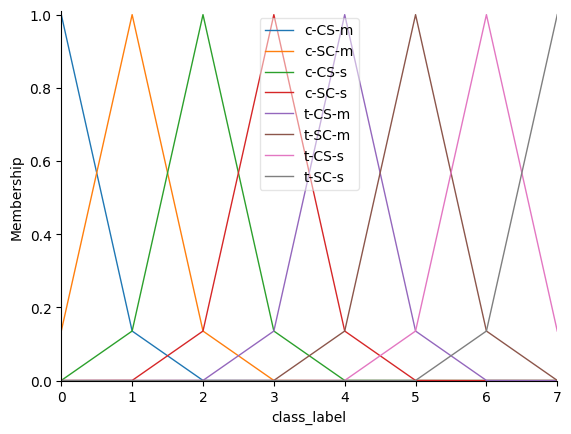

In [917]:
# Define output using gaussian membership function
class_label['c-CS-m'] = fuzz.gaussmf(class_label.universe, 0, 0.5)  
class_label['c-SC-m'] = fuzz.gaussmf(class_label.universe, 1, 0.5)
class_label['c-CS-s'] = fuzz.gaussmf(class_label.universe, 2, 0.5)
class_label['c-SC-s'] = fuzz.gaussmf(class_label.universe, 3, 0.5)
class_label['t-CS-m'] = fuzz.gaussmf(class_label.universe, 4, 0.5)
class_label['t-SC-m'] = fuzz.gaussmf(class_label.universe, 5, 0.5)
class_label['t-CS-s'] = fuzz.gaussmf(class_label.universe, 6, 0.5)
class_label['t-SC-s'] = fuzz.gaussmf(class_label.universe, 7, 0.5)

# Display membership functions for the output variable
class_label.view()

## Fuzzy Rule Base

In [918]:
# Define fuzzy rule 
rule1 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] & CaNA_N['high'] | Ubiquitin_N['medium'] |
         S6_N['medium'] | pPKCAB_N['medium'] | 
         pERK_N['medium'])
    ),
    consequent=class_label['c-CS-m']
)

rule2 = ctrl.Rule(
    antecedent=(
        (pS6_N['medium'] & P38_N['high'] |
         S6_N['low'] & pPKCAB_N['low'] & pGSK3B_N['low'] )
    ),
    consequent=class_label['c-SC-m']
)

rule3 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | CaNA_N['high'] | 
         S6_N['medium'] & pPKCAB_N['high'] & pGSK3B_N['high'] |
         pERK_N['medium'])
    ),
    consequent=class_label['c-CS-s']
)

rule4 = ctrl.Rule(
    antecedent=(
        (SOD1_N['high'] & Ubiquitin_N['medium'] &
         ARC_N['high'] & P38_N['high'] |
         pGSK3B_N['low'] & pERK_N['low'])
    ),
    consequent=class_label['c-SC-s']
)

rule5 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | pS6_N['low'] | 
         P38_N['low'] | S6_N['medium'] & 
         pPKCAB_N['medium'] & pERK_N['high'])
    ),
    consequent=class_label['t-CS-m']
)

rule6 = ctrl.Rule(
    antecedent=(
        (Ubiquitin_N['high'] & pS6_N['high'] |
         S6_N['low'] | pPKCAB_N['low'] | 
         pERK_N['low'])
    ),
    consequent=class_label['t-SC-m']
)

rule7 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | CaNA_N['high'] |
         P38_N['low'] |S6_N['high'] & pPKCAB_N['medium'] &
         pERK_N['medium'])
    ),
    consequent=class_label['t-CS-s']
)

rule8 = ctrl.Rule(
    antecedent=(
        (SOD1_N['medium'] & CaNA_N['medium'] & Ubiquitin_N['medium'] &
         S6_N['high'] | pPKCAB_N['medium'] | pGSK3B_N['medium'] |
         pERK_N['low'])
    ),
    consequent=class_label['t-SC-s']
)


In [919]:
# Create control system 
mice_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])


# Define control system simulation 
mice_ctrl_sim = ctrl.ControlSystemSimulation(mice_ctrl)

## Fuzzy Inference and Output

In [920]:
results = {
    'prediction1_A': [],
    'actual_A': [],
    'prediction2_A': []
}

# Assuming X contains your input features and y contains the mice class
for i in range(len(X)):
    input_values = {
        'SOD1_N': X.iloc[i]['SOD1_N'],
        'CaNA_N': X.iloc[i]['CaNA_N'],
        'Ubiquitin_N': X.iloc[i]['Ubiquitin_N'],
        'ARC_N': X.iloc[i]['ARC_N'],
        'pS6_N': X.iloc[i]['pS6_N'],
        'P38_N': X.iloc[i]['P38_N'],
        'S6_N': X.iloc[i]['S6_N'],
        'pPKCAB_N': X.iloc[i]['pPKCAB_N'],
        'pGSK3B_N': X.iloc[i]['pGSK3B_N'],
        'pERK_N': X.iloc[i]['pERK_N']
    }

    output_value = y.iloc[i]  # Assuming y contains the mice class

    # Compute output
    for key, value in input_values.items():
        mice_ctrl_sim.input[key] = value

    mice_ctrl_sim.compute()
    results['actual_A']+=[y.iloc[i]]
    results['prediction1_A'].append(mice_ctrl_sim.output['class_label'])
    results['prediction2_A']+=[mice_ctrl_sim.output['class_label'].astype(int)]




In [921]:
# Print output
output_df = pd.DataFrame({
    'Predicted Mice class': results['prediction2_A'],
    'Actual Mice class': results['actual_A']
})

# Print the DataFrame
print("\nOutput:")
print(output_df)


Output:
      Predicted Mice class  Actual Mice class
0                        3                  0
1                        3                  0
2                        3                  0
3                        3                  0
4                        3                  0
...                    ...                ...
1075                     4                  7
1076                     3                  7
1077                     3                  7
1078                     3                  7
1079                     3                  7

[1080 rows x 2 columns]


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


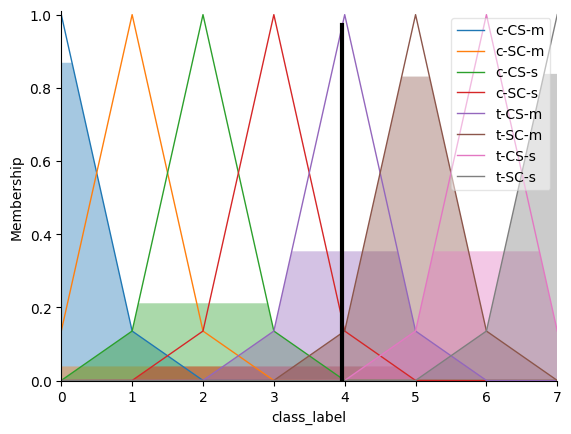

In [922]:
# Show the output membership function
class_label.view(sim=mice_ctrl_sim)

#### Model Evaluation

In [923]:
mse_A = mean_squared_error(results['actual_A'], results['prediction2_A'])
print("Mean Square Error: " + str(mse_A))


acc_A = accuracy_score(results['actual_A'],results['prediction2_A'])
print("Accuracy: "+str(acc_A))

Mean Square Error: 5.309259259259259
Accuracy: 0.12314814814814815


## Output Defuzzification

In [924]:
# Define centroid deffuzification calculation
def centroid_defuzzification(mf_values):
    numerator = sum(mf_values)
    denominator = len(mf_values)
    return numerator / denominator if denominator != 0 else 0

# Extract membership function values from 'prediction' and 'prediction2'
mf_values_prediction = results['prediction1_A']


# Perform defuzzification
crisp_value_prediction_A = centroid_defuzzification(mf_values_prediction)


# Print defuzzified values
print("\nDefuzzified Values:")
print("Crisp Value (Prediction):", crisp_value_prediction_A)


Defuzzified Values:
Crisp Value (Prediction): 3.6515398862839694


## Fine-Tune and Testing - with different membership function and rules

### Model B

#### Manually define membership functions for input variables - Each degree with same triangle membership function

In [925]:
# Define value for triangle membership function
mf_val = np.array([
    0.25, 0.94, 1.26,
    0.94, 1.26, 1.88,
    1.26, 1.88, 2.00,

    0.5, 0.9, 1.3,
    0.9, 1.3, 1.7,
    1.3, 1.7, 2.2,

    0.5, 0.8, 1.2,
    0.8, 1.2, 1.5,
    1.2, 1.5, 2.0,
    
    0.02,0.08,0.11,
    0.08,0.11,0.13,
    0.11,0.13,0.16,
    
    0.02,0.06,0.09,
    0.06,0.09,0.12,
    0.09,0.12,0.16,

    0.2, 0.4, 0.6,
    0.4, 0.6, 0.8,
    0.6, 0.8, 1.0,

    0.1, 0.2, 0.4,
    0.2, 0.4, 0.6,
    0.4, 0.6, 0.9,
    
    0.5, 1.3, 1.9,
    1.3, 1.9, 2.3,
    1.9, 2.3, 3.0,
    
    0.10,0.14,0.19,
    0.14,0.19,0.23,
    0.19,0.23,0.26,
    
    0.1, 0.8, 1.4,
    0.8, 1.4, 2.6,
    1.4 ,2.6, 3.5,
])

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


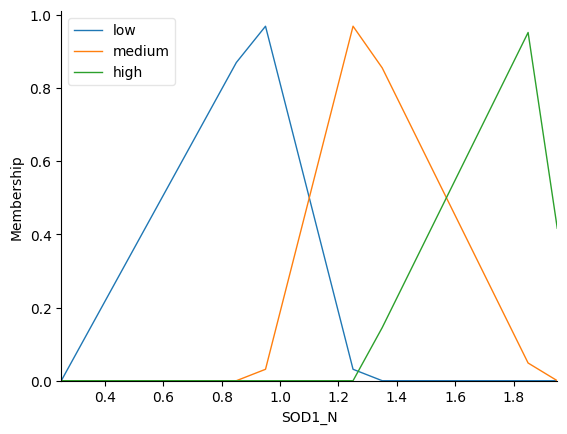

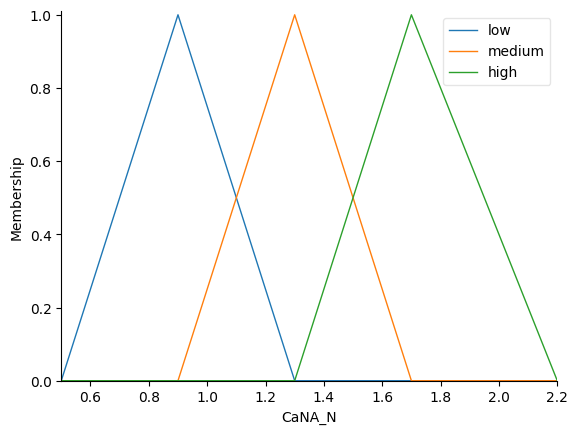

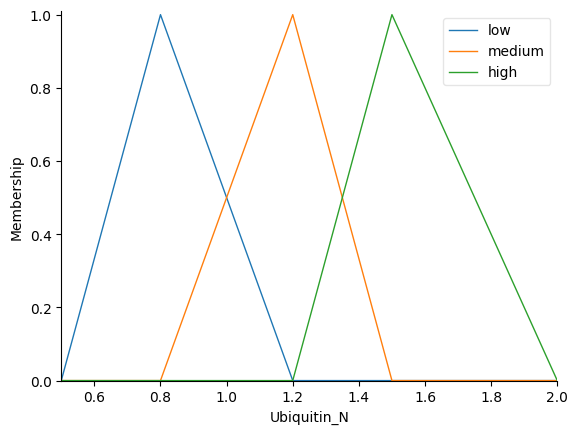

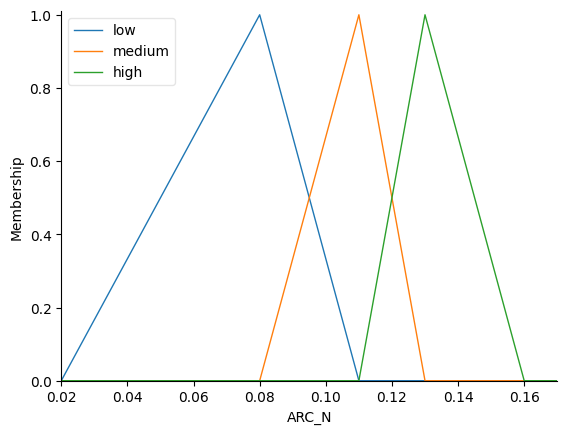

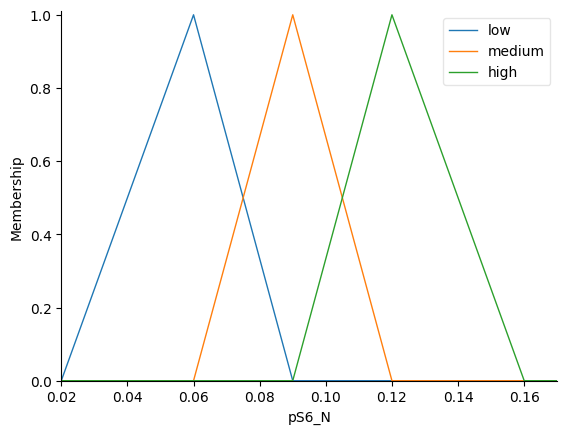

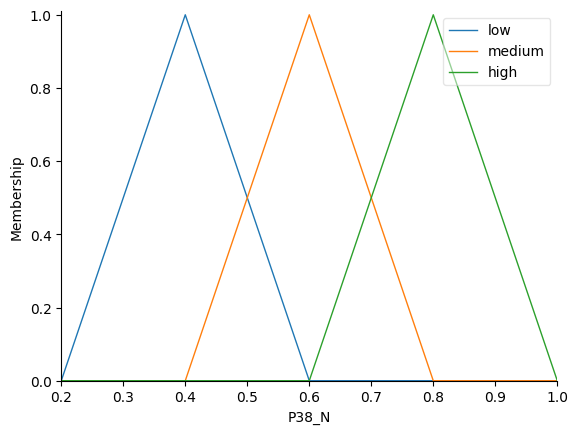

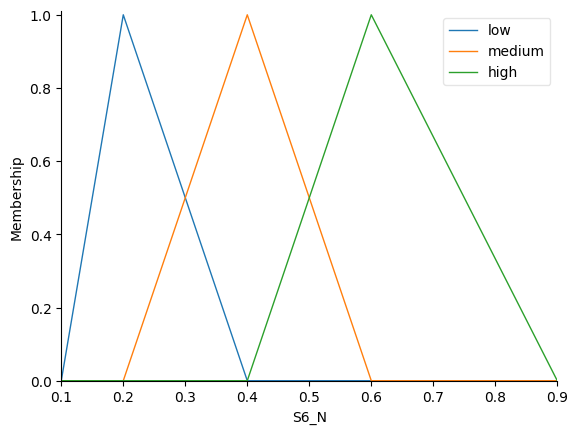

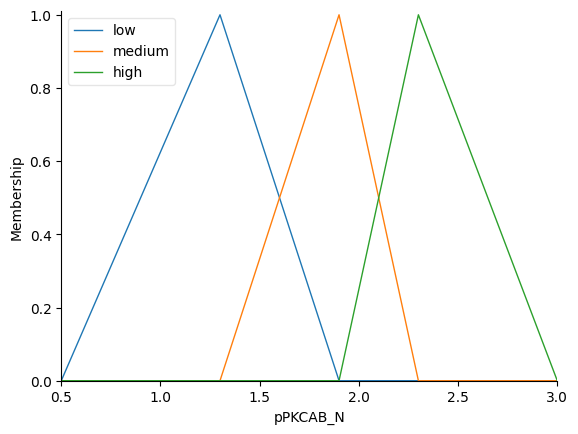

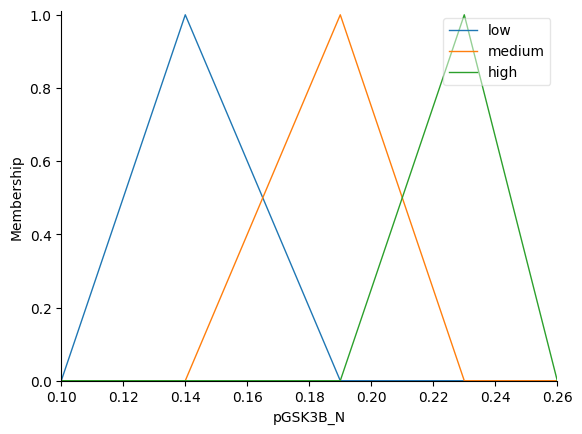

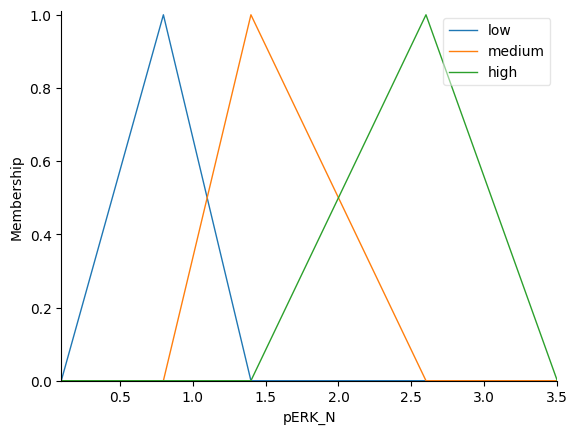

In [926]:
# Define membership function
SOD1_N['low'] = fuzz.trimf(SOD1_N.universe, [mf_val[0], mf_val[1], mf_val[2]])
SOD1_N['medium'] = fuzz.trimf(SOD1_N.universe, [mf_val[3], mf_val[4], mf_val[5]])
SOD1_N['high'] = fuzz.trimf(SOD1_N.universe, [mf_val[6], mf_val[7], mf_val[8]])

CaNA_N['low'] = fuzz.trimf(CaNA_N.universe, [mf_val[9], mf_val[10], mf_val[11]])
CaNA_N['medium'] = fuzz.trimf(CaNA_N.universe, [mf_val[12], mf_val[13], mf_val[14]])
CaNA_N['high'] = fuzz.trimf(CaNA_N.universe, [mf_val[15], mf_val[16], mf_val[17]])

Ubiquitin_N['low'] = fuzz.trimf(Ubiquitin_N.universe, [mf_val[18], mf_val[19], mf_val[20]])
Ubiquitin_N['medium'] = fuzz.trimf(Ubiquitin_N.universe, [mf_val[21], mf_val[22], mf_val[23]])
Ubiquitin_N['high'] = fuzz.trimf(Ubiquitin_N.universe, [mf_val[24], mf_val[25], mf_val[26]])

ARC_N['low'] = fuzz.trimf(ARC_N.universe, [mf_val[27], mf_val[28], mf_val[29]])
ARC_N['medium'] = fuzz.trimf(ARC_N.universe, [mf_val[30], mf_val[31], mf_val[32]])
ARC_N['high'] = fuzz.trimf(ARC_N.universe, [mf_val[33], mf_val[34], mf_val[35]])

pS6_N['low'] = fuzz.trimf(pS6_N.universe, [mf_val[36], mf_val[37], mf_val[38]])
pS6_N['medium'] = fuzz.trimf(pS6_N.universe, [mf_val[39], mf_val[40], mf_val[41]])
pS6_N['high'] = fuzz.trimf(pS6_N.universe, [mf_val[42], mf_val[43], mf_val[44]])

P38_N['low'] = fuzz.trimf(P38_N.universe, [mf_val[45], mf_val[46], mf_val[47]])
P38_N['medium'] = fuzz.trimf(P38_N.universe, [mf_val[48], mf_val[49], mf_val[50]])
P38_N['high'] = fuzz.trimf(P38_N.universe, [mf_val[51], mf_val[52], mf_val[53]])

S6_N['low'] = fuzz.trimf(S6_N.universe, [mf_val[54], mf_val[55], mf_val[56]])
S6_N['medium'] = fuzz.trimf(S6_N.universe, [mf_val[57], mf_val[58], mf_val[59]])
S6_N['high'] = fuzz.trimf(S6_N.universe, [mf_val[60], mf_val[61], mf_val[62]])

pPKCAB_N['low'] = fuzz.trimf(pPKCAB_N.universe, [mf_val[63], mf_val[64], mf_val[65]])
pPKCAB_N['medium'] = fuzz.trimf(pPKCAB_N.universe, [mf_val[66], mf_val[67], mf_val[68]])
pPKCAB_N['high'] = fuzz.trimf(pPKCAB_N.universe, [mf_val[69], mf_val[70], mf_val[71]])

pGSK3B_N['low'] = fuzz.trimf(pGSK3B_N.universe, [mf_val[72], mf_val[73], mf_val[74]])
pGSK3B_N['medium'] = fuzz.trimf(pGSK3B_N.universe, [mf_val[75], mf_val[76], mf_val[77]])
pGSK3B_N['high'] = fuzz.trimf(pGSK3B_N.universe, [mf_val[78], mf_val[79], mf_val[80]])

pERK_N['low'] = fuzz.trimf(pERK_N.universe, [mf_val[81], mf_val[82], mf_val[83]])
pERK_N['medium'] = fuzz.trimf(pERK_N.universe, [mf_val[84], mf_val[85], mf_val[86]])
pERK_N['high'] = fuzz.trimf(pERK_N.universe, [mf_val[87], mf_val[88], mf_val[89]])

# Display membership functions for each input variable
SOD1_N.view()
CaNA_N.view()
Ubiquitin_N.view()
ARC_N.view()
pS6_N.view()
P38_N.view()
S6_N.view()
pPKCAB_N.view()
pGSK3B_N.view()
pERK_N.view()

#### Define membership functions for the output variable (class) using triagle membership function

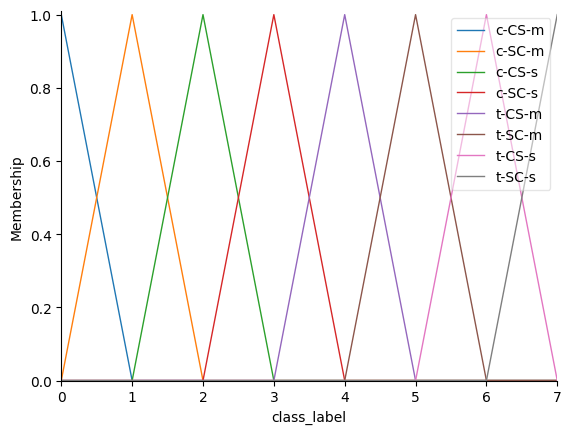

In [927]:
# Define output using triangle membership function
class_label['c-CS-m'] = fuzz.trimf(class_label.universe, [0, 0, 1])
class_label['c-SC-m'] = fuzz.trimf(class_label.universe, [0, 1, 2])
class_label['c-CS-s'] = fuzz.trimf(class_label.universe, [1, 2, 3])
class_label['c-SC-s'] = fuzz.trimf(class_label.universe, [2, 3, 4])
class_label['t-CS-m'] = fuzz.trimf(class_label.universe, [3, 4, 5])
class_label['t-SC-m'] = fuzz.trimf(class_label.universe, [4, 5, 6])
class_label['t-CS-s'] = fuzz.trimf(class_label.universe, [5, 6, 7])
class_label['t-SC-s'] = fuzz.trimf(class_label.universe, [6, 7, 8])

# Display membership functions for the output variable
class_label.view()

## Fuzzy rule base

In [928]:
# Define a different set of fuzzy rule
rule1 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] & CaNA_N['high'] | Ubiquitin_N['medium'] |
         ARC_N['medium'] | pS6_N['medium'] | P38_N['medium'] |
         pERK_N['medium'])
    ),
    consequent=class_label['c-CS-m']
)

rule2 = ctrl.Rule(
    antecedent=(
        ( CaNA_N['low'] & Ubiquitin_N['high'] |
         P38_N['high'] |
         S6_N['low'] & pPKCAB_N['low'] & pGSK3B_N['low'] &
         pERK_N['low'])
    ),
    consequent=class_label['c-SC-m']
)

rule3 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | CaNA_N['high'] | 
         ARC_N['low'] | 
         S6_N['medium'] & pPKCAB_N['high']  |
         pERK_N['medium'])
    ),
    consequent=class_label['c-CS-s']
)

rule4 = ctrl.Rule(
    antecedent=(
        (SOD1_N['high']  & Ubiquitin_N['medium'] &
         ARC_N['high'] & pS6_N['high'] |
         S6_N['low'] | pPKCAB_N['low'] & pGSK3B_N['low'] )
    ),
    consequent=class_label['c-SC-s']
)

rule5 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | CaNA_N['high'] | Ubiquitin_N['low'] |
         S6_N['medium'] & pPKCAB_N['medium'] & pGSK3B_N['medium']&
         pERK_N['high'])
    ),
    consequent=class_label['t-CS-m']
)

rule6 = ctrl.Rule(
    antecedent=(
        (SOD1_N['high'] & CaNA_N['low'] | pS6_N['high'] | 
         S6_N['low'] | pPKCAB_N['low'] | pGSK3B_N['low'] |
         pERK_N['low'])
    ),
    consequent=class_label['t-SC-m']
)

rule7 = ctrl.Rule(
    antecedent=(
        (SOD1_N['low'] | CaNA_N['high'] | Ubiquitin_N['low'] |
         ARC_N['low'] | pS6_N['low'] | P38_N['low'] |
         pERK_N['medium'])
    ),
    consequent=class_label['t-CS-s']
)

rule8 = ctrl.Rule(
    antecedent=(
        (SOD1_N['medium'] & CaNA_N['medium'] & Ubiquitin_N['medium'] &
         ARC_N['medium'] |
         S6_N['high'] | pPKCAB_N['medium'] | pGSK3B_N['medium'] |
         pERK_N['low'])
    ),
    consequent=class_label['t-SC-s']
)


In [929]:
# Create control system 
mice_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])


# Define control system simulation 
mice_ctrl_sim = ctrl.ControlSystemSimulation(mice_ctrl)

## Fuzzy Inference and Output

In [930]:
results = {
    'prediction1_B': [],
    'actual_B': [],
    'prediction2_B': []
}

# Assuming X contains your input features and y contains the mice class
for i in range(len(X)):
    input_values = {
        'SOD1_N': X.iloc[i]['SOD1_N'],
        'CaNA_N': X.iloc[i]['CaNA_N'],
        'Ubiquitin_N': X.iloc[i]['Ubiquitin_N'],
        'ARC_N': X.iloc[i]['ARC_N'],
        'pS6_N': X.iloc[i]['pS6_N'],
        'P38_N': X.iloc[i]['P38_N'],
        'S6_N': X.iloc[i]['S6_N'],
        'pPKCAB_N': X.iloc[i]['pPKCAB_N'],
        'pGSK3B_N': X.iloc[i]['pGSK3B_N'],
        'pERK_N': X.iloc[i]['pERK_N']
    }

    output_value = y.iloc[i]  # Assuming y contains the mice class

    # Compute output
    for key, value in input_values.items():
        mice_ctrl_sim.input[key] = value

    mice_ctrl_sim.compute()
    results['actual_B']+=[y.iloc[i]]
    results['prediction1_B'].append(mice_ctrl_sim.output['class_label'])
    results['prediction2_B']+=[mice_ctrl_sim.output['class_label'].astype(int)]


In [931]:
# Print output
output_df = pd.DataFrame({
    'Predicted Mice class': results['prediction2_B'],
    'Actual Mice class': results['actual_B']
})

# Print the DataFrame
print("\nOutput:")
print(output_df)


Output:
      Predicted Mice class  Actual Mice class
0                        3                  0
1                        3                  0
2                        3                  0
3                        3                  0
4                        3                  0
...                    ...                ...
1075                     3                  7
1076                     3                  7
1077                     3                  7
1078                     3                  7
1079                     3                  7

[1080 rows x 2 columns]


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


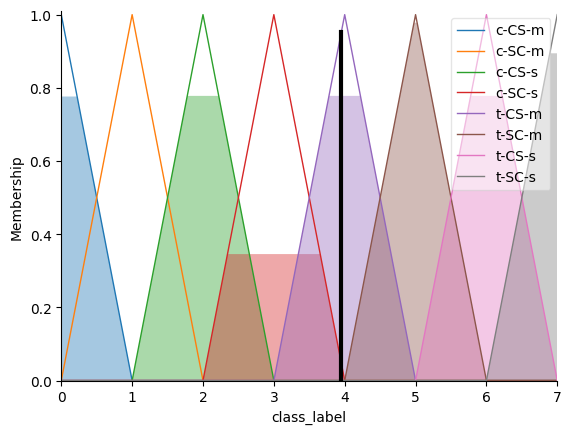

In [932]:
# Show the output membership function
class_label.view(sim=mice_ctrl_sim)

#### Model Evaluation

In [933]:
mse_B = mean_squared_error(results['actual_B'], results['prediction2_B'])
print("Mean Square Error: " + str(mse_B))


acc_B = accuracy_score(results['actual_B'],results['prediction2_B'])
print("Accuracy: "+str(acc_B))

Mean Square Error: 5.6342592592592595
Accuracy: 0.15925925925925927


## Output Deffuzification

In [934]:
def centroid_defuzzification(mf_values):
    numerator = sum(mf_values)
    denominator = len(mf_values)
    return numerator / denominator if denominator != 0 else 0

# Extract membership function values from 'prediction' and 'prediction2'
mf_values_prediction = results['prediction1_B']


# Perform defuzzification
crisp_value_prediction_B = centroid_defuzzification(mf_values_prediction)


# Print defuzzified values
print("\nDefuzzified Values:")
print("Crisp Value (Prediction):", crisp_value_prediction_B)



Defuzzified Values:
Crisp Value (Prediction): 3.84469275523503


## Comparision of Model A and Model B

In [935]:
# Create DataFrames for Model A and Model B results
results_summary_A = pd.DataFrame({
    'Model A': [mse_A, acc_A, crisp_value_prediction_A]
}, index=['MSE', 'Accuracy', 'Crisp Value'])

results_summary_B = pd.DataFrame({
    'Model B': [mse_B, acc_B, crisp_value_prediction_B]
}, index=['MSE', 'Accuracy', 'Crisp Value'])

# Concatenate DataFrames horizontally
comparison_summary = pd.concat([results_summary_A, results_summary_B], axis=1)

# Print the comparison
print(comparison_summary)



              Model A   Model B
MSE          5.309259  5.634259
Accuracy     0.123148  0.159259
Crisp Value  3.651540  3.844693


MSE (Mean Squared Error): A lower MSE indicates better performance, as it represents the average squared difference between the actual and predicted values. In this case, Model A has an MSE of 5.309259, while Model B has an MSE of 5.634259. Since Model A has a lower MSE, it performs slightly better in terms of minimizing the squared errors.

Accuracy: Higher accuracy signifies better performance in classification tasks. Model A has an accuracy of 0.123148, while Model B has an accuracy of 0.159259. Therefore, Model B has a higher accuracy, indicating an improvement in correctly classifying instances compared to Model A.

Crisp Value: The crisp value represents the defuzzified output of the fuzzy inference system. In this case, Model A has a crisp value of 3.651540, while Model B has a crisp value of 3.844693. Since Model B has a higher crisp value, it suggests a more confident prediction compared to Model A.

In conclusion, Model B improves in accuracy and confidence of predictions after fine-tuning from Model A